In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

Wed Sep 28 11:18:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:2D:00.0 Off |                  Off |
| 30%   31C    P8    22W / 230W |    181MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
#import sklearn
#assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import math
import time 
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import tensorflow as tf
tf.config.list_physical_devices()

2022-09-28 11:18:23.741093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-28 11:18:23.807412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2022-09-28 11:18:23.807447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-28 11:18:23.810130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-28 11:18:23.810201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-09-28 11:18:23.812547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


# CFD Parameters

In [6]:
dt = 0.4
dx = 1.0
Re = 1/20 
ub = 1
sigma = 100000  # bluff body
nx = 512
ny = 512
nz = 512
nlevel = 10

# Weights of CNNs layers

In [7]:
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

In [8]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*dt/dx*0.5
w2[0,1,:,:,0] = np.array(p_div_x2)*dt/dx*0.5
w2[0,2,:,:,0] = np.array(p_div_x3)*dt/dx*0.5

w3[0,0,:,:,0] = np.array(p_div_y1)*dt/dx*0.5
w3[0,1,:,:,0] = np.array(p_div_y2)*dt/dx*0.5
w3[0,2,:,:,0] = np.array(p_div_y3)*dt/dx*0.5 

w4[0,0,:,:,0] = np.array(p_div_z1)*dt/dx*0.5 
w4[0,1,:,:,0] = np.array(p_div_z2)*dt/dx*0.5
w4[0,2,:,:,0] = np.array(p_div_z3)*dt/dx*0.5

In [9]:
pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2 

In [10]:
pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/(dx*dt)*0.5
w6[0,1,:,:,0] = np.array(pctyu2)/(dx*dt)*0.5
w6[0,2,:,:,0] = np.array(pctyu3)/(dx*dt)*0.5
w7[0,0,:,:,0] = np.array(pctyv1)/(dx*dt)*0.5
w7[0,1,:,:,0] = np.array(pctyv2)/(dx*dt)*0.5
w7[0,2,:,:,0] = np.array(pctyv3)/(dx*dt)*0.5 
w8[0,0,:,:,0] = np.array(pctyw1)/(dx*dt)*0.5
w8[0,1,:,:,0] = np.array(pctyw2)/(dx*dt)*0.5
w8[0,2,:,:,0] = np.array(pctyw3)/(dx*dt)*0.5
w9[0,:,:,:,0] = 0.125

In [11]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [13]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


CNN3D_pu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_pw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [14]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer)
    ])

In [15]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    

In [16]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*2**i, 1*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [22]:
def boundary_condition_velocity(values_u,values_v,values_w,nx):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
    tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    
    tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    

    tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
    tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])   
    tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
    tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
    tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    tempu[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    tempu[0,nx-1,:,:,0].assign(tf.Variable(values_u)[0,nx-2,:,:,0])      
    tempv[0,nx-1,:,:,0].assign(tf.Variable(values_v)[0,nx-2,:,:,0])     
    tempw[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    tempp[0,nx-1,:,:,0].assign(tf.Variable(values_p)[0,nx-2,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])
    return tempb

def bluff_body(values_u,values_v,values_w,alpha,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    temp4 = alpha / (1+dt*sigma)
    return temp1,temp2,temp3,temp4

def save_data(alpha,n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("data_SK_tracer/alpha"+str(itime), arr=alpha[0,:,:,:,0])
        np.save("data_SK_tracer/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("data_SK_tracer/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("data_SK_tracer/p"+str(itime), arr=values_p[0,:,:,:,0])

# Initialise

In [27]:
#################### Create field #####£###############
input_shape = (1,nx,ny,nz,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 5         # Iterations of multi-grid 
j_itr = 1             # Iterations of Jacobi 
ntime = 500           # Time steps
n_out = 200           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0         # Last ctime for restart
mgsolver = True       # Multigrid solver
save_fig = True       # Save results
Restart = False       # Restart
LSCALAR = True        # Scalar transport 
LIBM = True           # Immersed boundary method 
ctime = 0             # Initialise ctime   
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('data_SK/u2500.npy').astype('float32')
    temp2 = np.load('data_SK/v2500.npy').astype('float32')
    temp3 = np.load('data_SK/w2500.npy').astype('float32')
    temp4 = np.load('data_SK/p2500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 2500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for restart ####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,0:256,:,:,0] = 1
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('mesh_512_sk.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i+64][j+64][k][0] == 0:
                    sigma[0][k][j][i][0] = 100000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
#######################################################
print('===================================================')

============== Numerical parameters ===============
Mesh resolution: (1, 512, 512, 512, 1)
Time step: 500
Initial time: 0
Switch on scalar filed solver!
Switch on IBM solver!


Text(0.5, 1.0, 'South Kensington area')

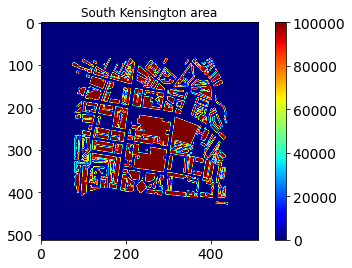

In [28]:
plt.imshow(sigma[0,1,:,:,0], cmap='jet')
plt.colorbar()
plt.title('South Kensington area')

Text(0.5, 1.0, 'Indicator field')

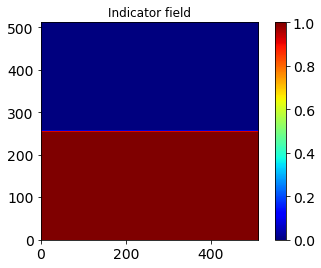

In [29]:
plt.imshow(alpha[0,:,256,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Indicator field')

# AI-HFM Solver

In [30]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)
    values_p = boundary_condition_pressure(values_p,nx)
# Momentum equation 
    a_u = CNN3D_central_2nd_dif(values_u) - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u
    a_v = CNN3D_central_2nd_dif(values_v) - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v
    a_w = CNN3D_central_2nd_dif(values_w) - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w)
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w,nx)
    
    c_u = CNN3D_central_2nd_dif(b_u) - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)
    values_u = values_u + c_u      
    c_v = CNN3D_central_2nd_dif(b_v) - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v)
    values_v = values_v + c_v
    c_w = CNN3D_central_2nd_dif(b_w) - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w)
    values_w = values_w + c_w    
# Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
# IBM 
    [values_u,values_v,values_w,alpha] = bluff_body(values_u,values_v,values_w,alpha,sigma)
# gradp            
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)  
    values_w = values_w - CNN3D_pw(values_p)     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)
# possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,1,1,1])
            r = CNN3D_A_512(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
            r_256 = CNN3D_res_512(r) 
            r_128 = CNN3D_res_256(r_256) 
            r_64 = CNN3D_res_128(r_128) 
            r_32 = CNN3D_res_64(r_64) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r_1 = CNN3D_res_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/w5[0,1,1,1,0] + r_1/w5[0,1,1,1,0])
            w_2 = CNN3D_prol_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])
            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])
            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])
            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])
            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])
            w_64 = CNN3D_prol_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/w5[0,1,1,1,0] + r_64/w5[0,1,1,1,0])
            w_128 = CNN3D_prol_64(w_64) 
            for Jacobi in range(j_itr):
                w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
            w_256 = CNN3D_prol_128(w_128)
            for Jacobi in range(j_itr):
                w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
            w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_512
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])         
            values_p = (values_p - CNN3D_A_512(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)  
    values_w = values_w - CNN3D_pw(values_p)       
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)      
    [values_u,values_v,values_w,alpha] = bluff_body(values_u,values_v,values_w,alpha,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_512), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_512)) > 0.2:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(alpha,n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

2022-09-28 11:50:02.956898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-28 11:55:07.619497: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-28 11:55:07.750913: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-28 11:55:09.145487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Time step: 1
Pressure error: 0.042788416 cty equation residual: 0.1534752
Time step: 2
Pressure error: 0.033846732 cty equation residual: 0.14037892
Time step: 3
Pressure error: 0.031988986 cty equation residual: 0.14402208
Time step: 4
Pressure error: 0.03156829 cty equation residual: 0.14810023
Time step: 5
Pressure error: 0.03162448 cty equation residual: 0.15136704
Time step: 6
Pressure error: 0.031845603 cty equation residual: 0.15386793
Time step: 7
Pressure error: 0.032102734 cty equation residual: 0.15576705
Time step: 8
Pressure error: 0.032344114 cty equation residual: 0.1572094
Time step: 9
Pressure error: 0.032553475 cty equation residual: 0.15830886
Time step: 10
Pressure error: 0.032730013 cty equation residual: 0.15915486
Time step: 11
Pressure error: 0.03287835 cty equation residual: 0.15981728
Time step: 12
Pressure error: 0.033004116 cty equation residual: 0.16035053
Time step: 13
Pressure error: 0.033112124 cty equation residual: 0.1607953
Time step: 14
Pressure erro

Time step: 63
Pressure error: 0.03402642 cty equation residual: 0.16506997
Time step: 64
Pressure error: 0.03402623 cty equation residual: 0.16507176
Time step: 65
Pressure error: 0.034026187 cty equation residual: 0.1650751
Time step: 66
Pressure error: 0.034026165 cty equation residual: 0.16507962
Time step: 67
Pressure error: 0.03402605 cty equation residual: 0.16508436
Time step: 68
Pressure error: 0.03402576 cty equation residual: 0.16508901
Time step: 69
Pressure error: 0.034025162 cty equation residual: 0.16509286
Time step: 70
Pressure error: 0.034024145 cty equation residual: 0.16509497
Time step: 71
Pressure error: 0.034022573 cty equation residual: 0.16509488
Time step: 72
Pressure error: 0.03402036 cty equation residual: 0.16509196
Time step: 73
Pressure error: 0.034017347 cty equation residual: 0.16508496
Time step: 74
Pressure error: 0.034013476 cty equation residual: 0.16507414
Time step: 75
Pressure error: 0.034008637 cty equation residual: 0.16505805
Time step: 76
Pres

Time step: 125
Pressure error: 0.03248498 cty equation residual: 0.15781596
Time step: 126
Pressure error: 0.03242895 cty equation residual: 0.1575486
Time step: 127
Pressure error: 0.03237163 cty equation residual: 0.15727505
Time step: 128
Pressure error: 0.032313056 cty equation residual: 0.15699545
Time step: 129
Pressure error: 0.032253295 cty equation residual: 0.15670976
Time step: 130
Pressure error: 0.032192152 cty equation residual: 0.15641776
Time step: 131
Pressure error: 0.03212962 cty equation residual: 0.15611926
Time step: 132
Pressure error: 0.032065768 cty equation residual: 0.15581432
Time step: 133
Pressure error: 0.03200058 cty equation residual: 0.15550295
Time step: 134
Pressure error: 0.031933922 cty equation residual: 0.15518484
Time step: 135
Pressure error: 0.03186595 cty equation residual: 0.15485993
Time step: 136
Pressure error: 0.0317965 cty equation residual: 0.15452784
Time step: 137
Pressure error: 0.031725533 cty equation residual: 0.15418896
Time ste

Time step: 187
Pressure error: 0.026291268 cty equation residual: 0.12799904
Time step: 188
Pressure error: 0.026156247 cty equation residual: 0.12734503
Time step: 189
Pressure error: 0.026020547 cty equation residual: 0.1266881
Time step: 190
Pressure error: 0.02588398 cty equation residual: 0.12602746
Time step: 191
Pressure error: 0.02574714 cty equation residual: 0.12536535
Time step: 192
Pressure error: 0.025610263 cty equation residual: 0.12510857
Time step: 193
Pressure error: 0.025472507 cty equation residual: 0.12506697
Time step: 194
Pressure error: 0.02533489 cty equation residual: 0.12502274
Time step: 195
Pressure error: 0.02519725 cty equation residual: 0.1249758
Time step: 196
Pressure error: 0.025058527 cty equation residual: 0.12492606
Time step: 197
Pressure error: 0.024920197 cty equation residual: 0.12487346
Time step: 198
Pressure error: 0.024782147 cty equation residual: 0.124818146
Time step: 199
Pressure error: 0.024752174 cty equation residual: 0.124759555
Tim

Time step: 249
Pressure error: 0.022958655 cty equation residual: 0.11685446
Time step: 250
Pressure error: 0.022903234 cty equation residual: 0.11660066
Time step: 251
Pressure error: 0.022847716 cty equation residual: 0.11634609
Time step: 252
Pressure error: 0.022792244 cty equation residual: 0.116090894
Time step: 253
Pressure error: 0.022736836 cty equation residual: 0.11583555
Time step: 254
Pressure error: 0.022681557 cty equation residual: 0.11558017
Time step: 255
Pressure error: 0.022626583 cty equation residual: 0.11532551
Time step: 256
Pressure error: 0.022571892 cty equation residual: 0.115071714
Time step: 257
Pressure error: 0.022517782 cty equation residual: 0.11481941
Time step: 258
Pressure error: 0.022464056 cty equation residual: 0.11456919
Time step: 259
Pressure error: 0.02241097 cty equation residual: 0.114320755
Time step: 260
Pressure error: 0.022358585 cty equation residual: 0.114075154
Time step: 261
Pressure error: 0.022306971 cty equation residual: 0.11383

Time step: 311
Pressure error: 0.025339885 cty equation residual: 0.123950124
Time step: 312
Pressure error: 0.025277264 cty equation residual: 0.12363678
Time step: 313
Pressure error: 0.02520638 cty equation residual: 0.123280644
Time step: 314
Pressure error: 0.025129225 cty equation residual: 0.122888565
Time step: 315
Pressure error: 0.025046153 cty equation residual: 0.12246773
Time step: 316
Pressure error: 0.024959 cty equation residual: 0.1220229
Time step: 317
Pressure error: 0.024869148 cty equation residual: 0.121563435
Time step: 318
Pressure error: 0.024777068 cty equation residual: 0.12109172
Time step: 319
Pressure error: 0.024682947 cty equation residual: 0.12061483
Time step: 320
Pressure error: 0.024588395 cty equation residual: 0.12013224
Time step: 321
Pressure error: 0.024492064 cty equation residual: 0.1196436
Time step: 322
Pressure error: 0.024394542 cty equation residual: 0.11915037
Time step: 323
Pressure error: 0.024295727 cty equation residual: 0.118652016


Time step: 373
Pressure error: 0.022607056 cty equation residual: 0.1152516
Time step: 374
Pressure error: 0.022578888 cty equation residual: 0.11512619
Time step: 375
Pressure error: 0.022549573 cty equation residual: 0.11499539
Time step: 376
Pressure error: 0.022519115 cty equation residual: 0.1148594
Time step: 377
Pressure error: 0.022487624 cty equation residual: 0.11471784
Time step: 378
Pressure error: 0.022455068 cty equation residual: 0.11457142
Time step: 379
Pressure error: 0.02242152 cty equation residual: 0.114420414
Time step: 380
Pressure error: 0.022387028 cty equation residual: 0.11426449
Time step: 381
Pressure error: 0.022351593 cty equation residual: 0.11410427
Time step: 382
Pressure error: 0.022315316 cty equation residual: 0.113939494
Time step: 383
Pressure error: 0.022278182 cty equation residual: 0.11377081
Time step: 384
Pressure error: 0.022240238 cty equation residual: 0.11359808
Time step: 385
Pressure error: 0.022201542 cty equation residual: 0.11342186


Time step: 435
Pressure error: 0.0201661 cty equation residual: 0.10344598
Time step: 436
Pressure error: 0.020134073 cty equation residual: 0.103274345
Time step: 437
Pressure error: 0.020102484 cty equation residual: 0.10311386
Time step: 438
Pressure error: 0.020071339 cty equation residual: 0.1029627
Time step: 439
Pressure error: 0.020040616 cty equation residual: 0.10281345
Time step: 440
Pressure error: 0.02001033 cty equation residual: 0.10266629
Time step: 441
Pressure error: 0.019980475 cty equation residual: 0.10252127
Time step: 442
Pressure error: 0.01995105 cty equation residual: 0.10237831
Time step: 443
Pressure error: 0.01992208 cty equation residual: 0.10223761
Time step: 444
Pressure error: 0.019893557 cty equation residual: 0.10209909
Time step: 445
Pressure error: 0.01986546 cty equation residual: 0.101962715
Time step: 446
Pressure error: 0.019837808 cty equation residual: 0.10182828
Time step: 447
Pressure error: 0.01981062 cty equation residual: 0.10169631
Time 

Time step: 497
Pressure error: 0.018950602 cty equation residual: 0.09752324
Time step: 498
Pressure error: 0.018940352 cty equation residual: 0.09747395
Time step: 499
Pressure error: 0.01893022 cty equation residual: 0.0974254
Time step: 500
Pressure error: 0.01892018 cty equation residual: 0.09737724
time 2529.886337041855


Text(0.5, 1.0, 'indicator field at central xy plane')

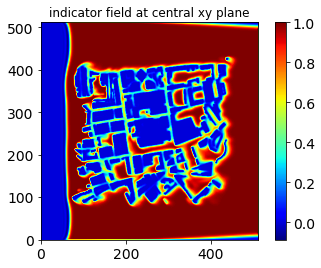

In [33]:
plt.imshow(alpha[0,50,:,:,0], cmap='jet', vmax=1.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('indicator field at central xy plane')

Text(0.5, 1.0, 'U-component velocity at central xy plane')

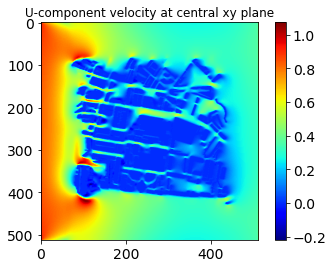

In [34]:
plt.imshow((values_u)[0,50,:,:,0], cmap='jet')
plt.colorbar()
plt.title('U-component velocity at central xy plane')

Text(0.5, 1.0, 'V-component velocity at central xy plane')

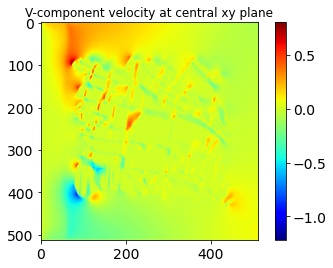

In [35]:
plt.imshow((values_v)[0,50,:,:,0], cmap='jet')
plt.colorbar()
plt.title('V-component velocity at central xy plane')

Text(0.5, 1.0, 'W-component velocity at central xy plane')

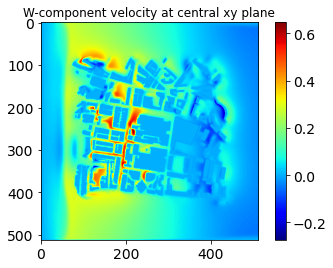

In [36]:
plt.imshow((values_w)[0,50,:,:,0], cmap='jet')
plt.colorbar()
plt.title('W-component velocity at central xy plane')

Text(0.5, 1.0, 'Pressure at central xy plane')

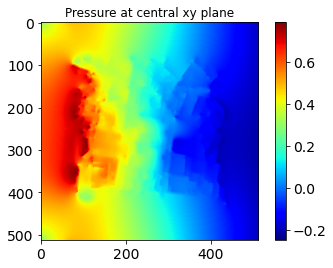

In [37]:
plt.imshow((values_p)[0,50,:,:,0], cmap='jet')
plt.colorbar()
plt.title('Pressure at central xy plane')